# Computer Vision - Project

In [1]:
#Importing all the necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D, ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 

from PIL import Image

from google.colab.patches import cv2_imshow

from zipfile import ZipFile
import glob
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import gc
import copy

# Face Recognition

### 1. Unzip, read and Load data(‘PINS.zip’) into session. [2 Marks]

In [38]:
#Unziping, Reading & Loading 'PINS.zip' file
pins_path = '/content/drive/MyDrive/Python - Collab/12. Module-9_Computer Vision/Computer Vision - Project/PINS.zip'

with ZipFile(pins_path, 'r') as z:
  z.extractall()

### 2. Write function to create metadata of the image. [4 Marks]

In [39]:
#Function to create metadata of the image:
class IdentityMetadata():
  def __init__(self, base, name, file):
    self.base = base
    self.name = name
    self.file = file

  def __repr__(self):
    return self.image_path()
    
  def image_path(self):
    return os.path.join(self.base, self.name, self.file)

### 3. Write a loop to iterate through each and every image and create metadata for all the images. [4 Marks]

In [40]:
#Creating function to load metadata
def load_metadata(path):
  metadata=[]
  for i in os.listdir(path):
    for f in os.listdir(os.path.join(path, i)):
      ext = os.path.splitext(f)[1]
      if ext == '.jpg' or ext == '.jpeg':
        metadata.append(IdentityMetadata(path, i, f))
  return np.array(metadata)

In [41]:
#Loading the PINS data
pins_metadata = load_metadata('PINS')

In [42]:
#Defining a function to load the image & converting it from BGR to RGB format
def load_image(path):
  img = cv2.imread(path, 1)
  return img[..., ::-1]

The Random Image to be displayed is of the Number 6457, which shows the picture of "Sarah Wayne Callies" 



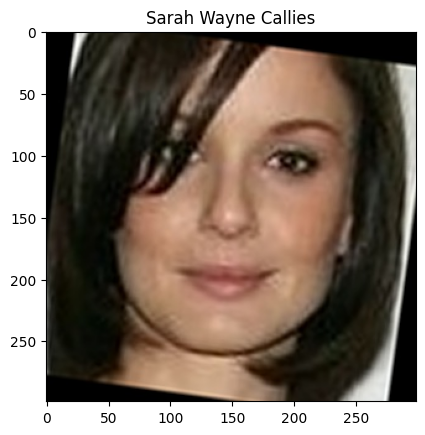

In [43]:
#Generating a random image, displaying the image along with the name of the person
num = np.random.randint(1, len(pins_metadata))

#Getting the name of the person whose picture is to be displayed
name = pins_metadata[int(num)].image_path().split('/')[1].split('_')[-1].title().strip()
print('The Random Image to be displayed is of the Number {}, which shows the picture of "{}"'.format(num, name), '\n')

#Loading the particular image
img1 = load_image(pins_metadata[int(num)].image_path())
plt.imshow(img1)
plt.title(name)
plt.show()

### 4. Generate Embeddings vectors on the each face in the dataset. [4 Marks]

In [44]:
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [45]:
#Loading the model
model = vgg_face()

#Loading the weights from pre-trained model & assigning them to our current model
model.load_weights('/content/drive/MyDrive/Python - Collab/12. Module-9_Computer Vision/Computer Vision - Project/vgg_face_weights.h5')

In [46]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [47]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = pins_metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

#Resizing the image to (224, 224)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 810ms/step
(2622,)


In [48]:
#Generating embedding vectors for all the images in the data
embeddings = np.zeros((pins_metadata.shape[0], 2622))

for i, m in enumerate(pins_metadata):
    img = load_image(str(m))
    img = (img/255.0).astype(np.float32)
    img = cv2.resize(img, dsize=(224, 224))

    embedding_vectors = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i] = embedding_vectors

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 1s/step


### 5. Build distance metrics for identifying the distance between two similar and dissimilar images. [4 Marks]

In [49]:
#Creating a function to measure distance between images
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [50]:
#Creating a function to show the different images & distance between them.
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(pins_metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(pins_metadata[idx2].image_path()));

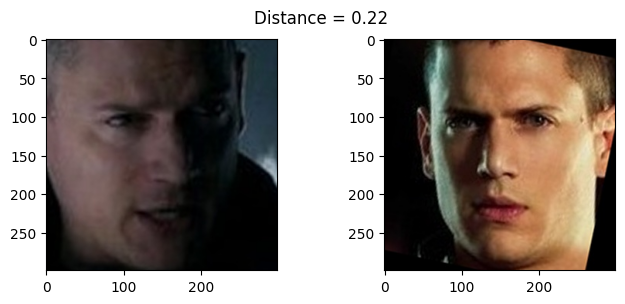

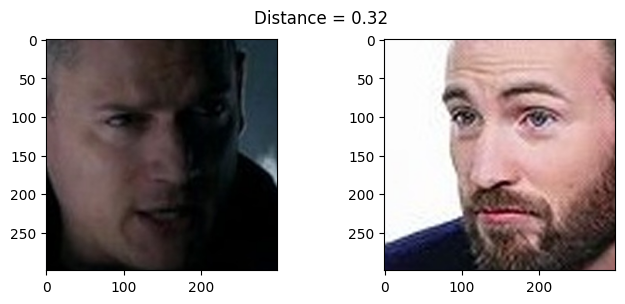

In [51]:
#Displaying the images & distance between images ([2, 3] & [2, 178])
show_pair(2, 3)
show_pair(2, 178)

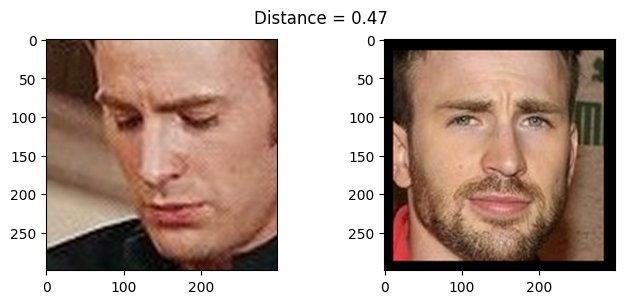

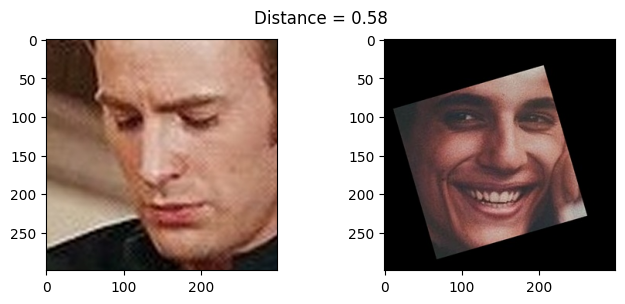

In [69]:
#Displaying the images & distance between images ([166, 167] & [166, 398])
show_pair(166, 167)
show_pair(166, 398)

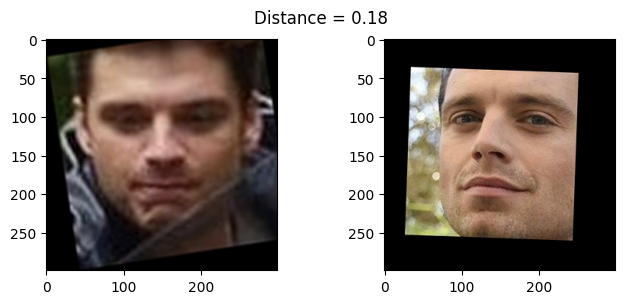

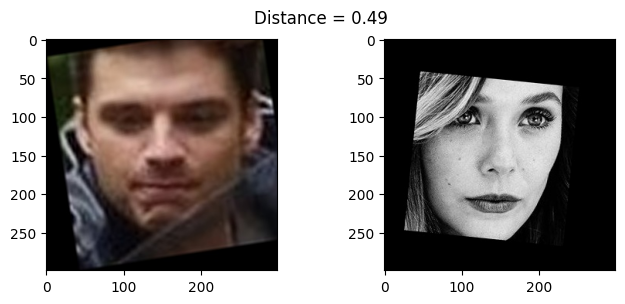

In [53]:
#Displaying the images & distance between images ([632, 634] & [632, 1201])
show_pair(632, 634)
show_pair(632, 1201)

### 6. Use PCA for dimensionality reduction. [2 Marks]

In [54]:
#Splitting the dataset into train & test sets
train_idx = np.arange(pins_metadata.shape[0]) % 9 != 0
test_idx = np.arange(pins_metadata.shape[0]) % 9 == 0

#Features
x_tr = embeddings[train_idx]
x_te = embeddings[test_idx]

#Labels
targets = np.array([m.name for m in pins_metadata])
y_tr = targets[train_idx]
y_te = targets[test_idx]

In [55]:
#Printing the shape of train & test sets
print('Shape of X_Train:', x_tr.shape)
print('Shape of X_Test:', x_te.shape)
print('Shape of Y_Train:', y_tr.shape)
print('Shape of Y_Test:', y_te.shape)

Shape of X_Train: (9573, 2622)
Shape of X_Test: (1197, 2622)
Shape of Y_Train: (9573,)
Shape of Y_Test: (1197,)


In [56]:
#Encoding the Labels using LabelEncoder
le = LabelEncoder()

y_trec = le.fit_transform(y_tr)
y_teec = le.transform(y_te)

In [57]:
#Standardizing the the features using StandardScaler
ss = StandardScaler()

x_trss = ss.fit_transform(x_tr)
x_tess = ss.fit_transform(x_te)

In [73]:
#Reducing the dimension of the features using PCA
pca = PCA()

x_tra = pca.fit_transform(x_trss)
x_tes = pca.transform(x_tess)

expl_var_rat = pca.explained_variance_ratio_
print('Explained Variance: \n', expl_var_rat, '\n')
print('Cumulative Variance: \n', np.cumsum(expl_var_rat))

Explained Variance: 
 [1.36106565e-01 5.38333111e-02 3.96093699e-02 ... 1.66074818e-09
 1.64111305e-09 9.25196657e-11] 

Cumulative Variance: 
 [0.13610656 0.18993988 0.22954925 ... 1.         1.         1.        ]


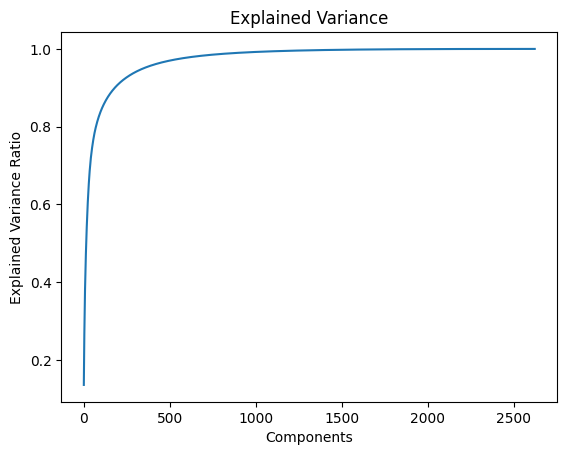

In [74]:
#Generating the Visualization of Cumulative Explained Varaiance Ratio
plt.figure()
plt.plot(np.cumsum(expl_var_rat))
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance')
plt.show()

In [75]:
#Checking the number of components required for minimum 95% of explained variance
for var in range(1, len(expl_var_rat)):
    if np.cumsum(expl_var_rat)[var]<0.95:
        var+=1
    else:
        thresh = var+1 #Here we take next value of var i.e. var + 1, because we have given condition till the cumulative sum
                       # is less than 0.95. Hence if we go just 1 value above that, 95% or more varaince explained is captured.
        break;

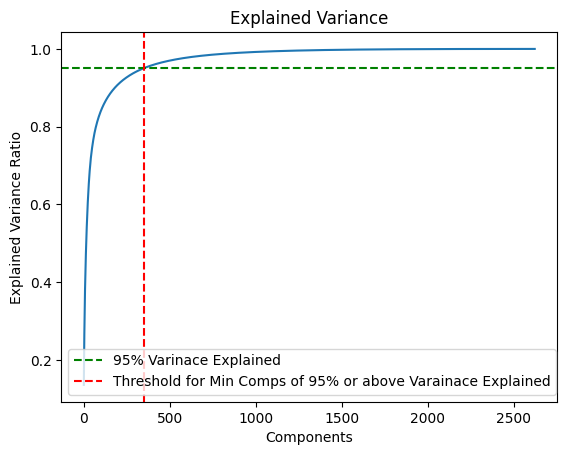

The No. of Compoents required to achieve 95% Variance as seen from the graph is: 348


In [76]:
#Generating the Visualization of Cumulative Explained Variance Ratio (Variance: 95% & No. of Components required to achieve it)
plt.figure()
plt.plot(np.cumsum(expl_var_rat))
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')
plt.axhline(y=0.95, color='g', label='95% Varinace Explained', linestyle='--')
plt.axvline(x=thresh, color='r', label='Threshold for Min Comps of 95% or above Varainace Explained', linestyle='--')
plt.legend(loc='best')
plt.title('Explained Variance')
plt.show()

print('The No. of Compoents required to achieve 95% Variance as seen from the graph is:', thresh)

In [77]:
#Reducing the dimensions to 348 which achieves 95% variance
pca = PCA(n_components=thresh)

x_tra = pca.fit_transform(x_trss)
x_tes = pca.transform(x_tess)

expl_var_rat = pca.explained_variance_ratio_
print('Explained Variance: \n', expl_var_rat, '\n')
print('Cumulative Variance: \n', np.cumsum(expl_var_rat))

Explained Variance: 
 [0.13610656 0.05383331 0.03960937 0.03700513 0.03387018 0.03143952
 0.02582719 0.0234154  0.02095512 0.01932146 0.01813131 0.01711916
 0.01655134 0.01576505 0.01417277 0.01364491 0.01304893 0.01218618
 0.01154347 0.0113892  0.01095696 0.01062335 0.00953322 0.00937588
 0.00907759 0.00876309 0.00836274 0.00763179 0.00755294 0.0073426
 0.00704007 0.00664904 0.00629095 0.00621509 0.00570475 0.00539014
 0.00525601 0.00509456 0.0049921  0.00487435 0.00442357 0.00433501
 0.00394029 0.0039191  0.00373269 0.00355754 0.0034236  0.00336013
 0.00328159 0.0031955  0.00313172 0.00309275 0.00291228 0.00280992
 0.00276039 0.00273392 0.00267562 0.00261362 0.00251958 0.00250494
 0.00238494 0.00231523 0.00223868 0.00216319 0.00212697 0.00206686
 0.00202137 0.00194839 0.00189385 0.00183004 0.00181687 0.00178022
 0.00176013 0.00171306 0.00169888 0.00167098 0.00164479 0.00160897
 0.0015731  0.00155507 0.00152881 0.00150265 0.00146124 0.00142724
 0.00142235 0.00138261 0.00137767 0.00133

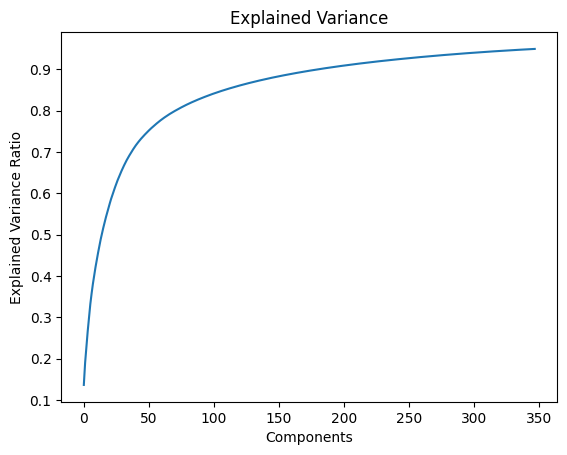

In [78]:
#Generating the Visulaization for Explained Variance with reduced dimensions
plt.figure()
plt.plot(np.cumsum(expl_var_rat))
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance')
plt.show()

### 7. Build an SVM classifier in order to map each image to its right person. [4 Marks]

In [64]:
#Building SVM Classifier
svc = SVC()

#Fitting the model
svc.fit(x_tra, y_trec)

#Predicting
y_pred_svc = svc.predict(x_tes)

In [65]:
#Getting the Accuracy of the model for training data
print('The Acccuracy of the SVC Model for Training Data is', svc.score(x_tra, y_trec))

The Acccuracy of the SVC Model for Training Data is 0.9975974093805494


In [66]:
#Printing the Accuracy of model for testing data
print('The Accuracy of the SVC Model for Testing Data is:', accuracy_score(y_teec, y_pred_svc))

The Accuracy of the SVC Model for Testing Data is: 0.9665831244778613


In [79]:
#Generating the Classification Report
names = [name.split('_')[-1].title().strip() for name in targets]
print('classification Report: \n {}'.format(classification_report(y_teec, y_pred_svc, target_names = np.unique(names))))

classification Report: 
                           precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00         9
      Alexandra Daddario       0.71      1.00      0.83        10
            Alvaro Morte       1.00      0.92      0.96        13
Alycia Debnam Carey Face       1.00      1.00      1.00        13
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      1.00      1.00         9
        Amber Heard Face       1.00      1.00      1.00         8
               Anna Gunn       0.93      0.93      0.93        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       1.00      1.00      1.00         9
      Bellamy Blake Face       0.82      1.00      0.90        14
    Benedict Cumberbatch       0.92      1.00      0.96        12
            Betsy Brandt       0.91      1.00      0.95        10
              Bill Gates       0.91      1.00     

### 8. Import and display the the test images. [2 Marks]

In [80]:
#Loading the test images using the 'load_image' function
test_img1 = load_image('/content/drive/MyDrive/Python - Collab/12. Module-9_Computer Vision/Computer Vision - Project/Benedict Cumberbatch9.jpg')
test_img2 = load_image('/content/drive/MyDrive/Python - Collab/12. Module-9_Computer Vision/Computer Vision - Project/Dwayne Johnson4.jpg') 

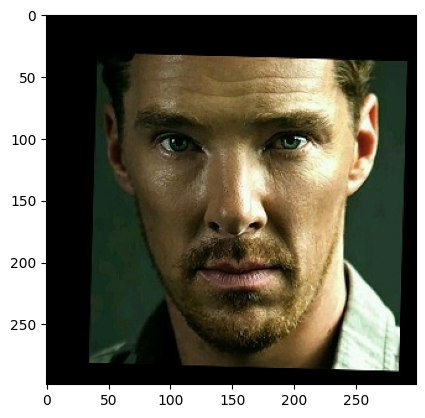

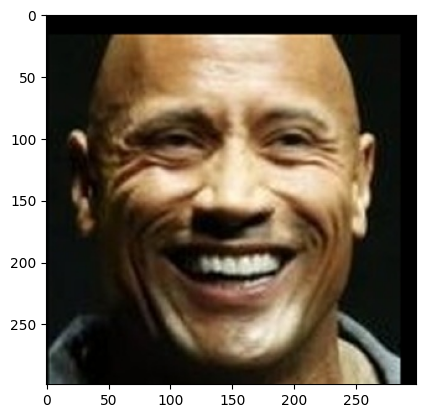

In [81]:
#Displaying the test images
plt.imshow(test_img1)
plt.show()
plt.imshow(test_img2)
plt.show()

### 9. Use the trained SVM model to predict the face on both test images. [4 Marks]

In [82]:
#Creating the function to predict the image
def predict_image(img):
  img = (img/255.).astype(np.float32)
  img = cv2.resize(img, (224, 224))
  img_emb = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
  img_emb_ss = ss.transform(img_emb.reshape(1,-1))
  img_emb_ss_pca = pca.transform(img_emb_ss)
  img_pred = svc.predict(img_emb_ss_pca)
  predicted_name = le.inverse_transform(img_pred)[0].split('_')[-1].title().strip()
  plt.imshow(img)
  plt.title(predicted_name)
  plt.show()
  print('\n')
  print('The Image is predicted to be of {}'.format(predicted_name))

1/1 [==============================] - 1s 634ms/step


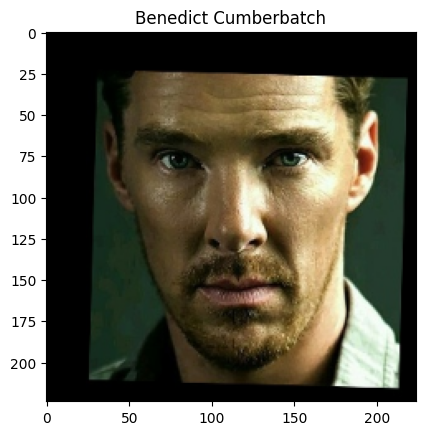



The Image is predicted to be of Benedict Cumberbatch


In [83]:
predict_image(test_img1)

1/1 [==============================] - 1s 620ms/step


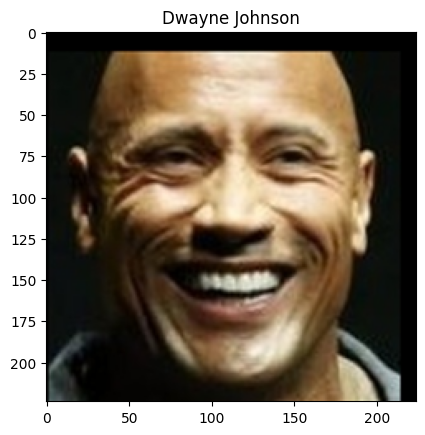



The Image is predicted to be of Dwayne Johnson


In [84]:
predict_image(test_img2)